<a href="https://colab.research.google.com/github/dkaratzas/ML2024-25/blob/main/Session%204%20-%20Regularisation/P4_Regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/ML2024-25/blob/main/Session%204%20-%20Regularisation/P4_Regularisation.ipynb>)

# Problems 4 - Regularisation

## 4.1 Improving the fit - Regression

Suppose you are fitting a linear regression model: $f(x) = w_0+w_1 x_1$ on the same training set as in last week.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pickle

# Load the House dataset
with open('PolynomialData.pkl', 'rb') as f:
    x, y = pickle.load(f)

print (x.shape)
print (y.shape)

(50, 1)
(50,)


Plotting these data looks like this:

Text(0, 0.5, 'Observed y (output)')

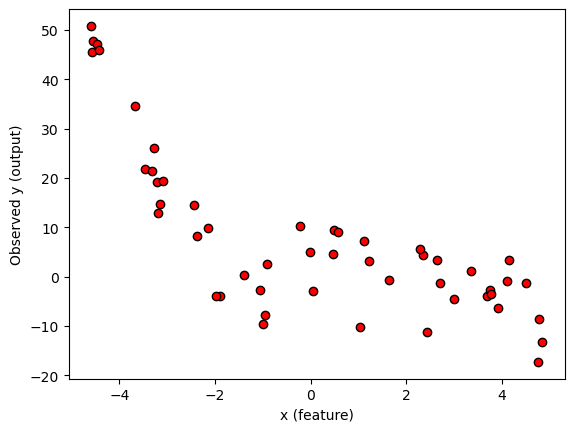

In [3]:
plt.scatter(x, y, marker = 'o', edgecolor = 'black', c = 'red')
plt.xlabel('x (feature)')
plt.ylabel('Observed y (output)')

Let's redefine our function `map_feature()` for generating polynomial features. Remember that we also normalise our data inside the same function. If we do so, we should keep the mean and standard deviation values we used for the normalisation, as we might need to use them again later on, with new data. Therefore, we **return** the mean and standard deviation values we calculated so that they can be saved for future use.

In addition, we made the mean and standard deviation variables into **arguments** of this function, that have a default value of an empty array. This way we can check what these arguments are everytime. If we are given nothing (therefore these are empty arrays), we will calculate the means and standard deviations inside our function and use them for the normalisation. If we are given something, then we will use the values we are given for normalization. This way we provide a neat mechanism to tell the function how to normalise each time.

In [4]:
def map_feature(x, degree = 6, preCalcMeans = None, preCalcStd = None):
    '''
    Maps a single 1D feature to polynomial features up to the degree given
    Returns a new feature vector comprising of
    1, x, x^2, x^3, ..., x^degree
    '''
    
    x = x.reshape(-1, 1) #make into a vector if it has any other shape. The function size returns the number of elements in an array
    
    DesignMatrix = np.ones_like(x) # start with a column of ones
    
    for i in range(1, degree + 1):
            c = x ** i
            DesignMatrix = np.append(DesignMatrix, c, axis=1)

    # Calculate means and standard deviation if not provided
    if preCalcMeans is None:
        mu = DesignMatrix.mean(axis = 0)
    else:
        mu = preCalcMeans
        
    if preCalcStd is None:
        sigma = DesignMatrix.std(axis = 0, ddof=1)
    else:
        sigma = preCalcStd
    
    # Standardise
    for i in range(1, degree + 1):
        DesignMatrix[:,i] = (DesignMatrix[:,i] - mu[i]) / sigma[i]
                
    return DesignMatrix, mu, sigma

We will also redefine our `GradientDescent_np()` for running the Gradient Descent algorithm.

In [5]:
def GradientDescent_np(X, y, max_iterations=100, alpha=1):
    m, n = X.shape # number of samples, number of features
    J = np.zeros(max_iterations)

    # y must be a column vector of shape m x 1
    y = y.reshape(m, 1)
    
    # Create as many parameters as features and initialize them to zero
    w = np.zeros(shape=(n, 1))
    
    # Repeat for max_iterations (it would be nice to also check convergence...)
    for iteration in range(max_iterations):
        grad = np.dot(X.T , (np.dot(X,w) - y)) / m;
        w = w - alpha*grad
        J[iteration] = sum( (np.dot(X,w) - y)**2) /(2*m)
    return [w, J]

Now, let's recover what we did in the last session. We will try polynomials of different degrees on our data, and see how the fit changes. In order to be easier to see, instead of running the code many times, we will do a figure with a few subplots.

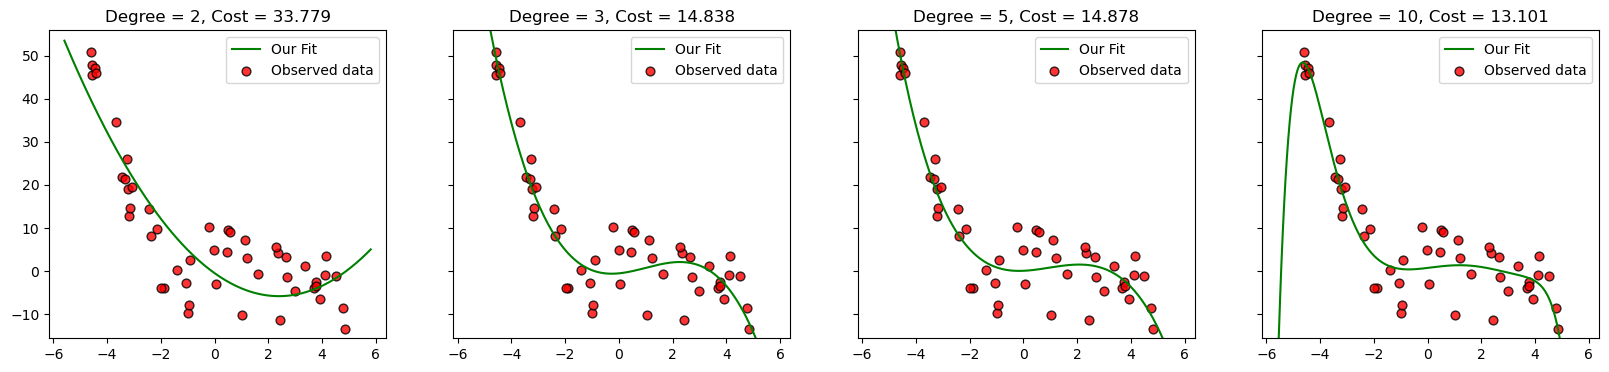

In [6]:
degreeRange = [2, 3, 5, 10] # Define the list of degrees we want to try out

fig, ax = plt.subplots(1, len(degreeRange), sharey = True, figsize = (20,4)) # Create a row of as many subplots as degrees we want to check

for deg, axis in zip(degreeRange, ax): # The zip() function "zips" two lists together, and creates a new list of tuples. See https://docs.python.org/3/library/functions.html#zip
    x_norm, means, stds = map_feature(x, degree = deg) # Generate features up to the corresponding degree

    w, J = GradientDescent_np(x_norm, y, alpha = 0.1, max_iterations=1500) # run our Gradient Descent

    # plot our FIT
    xx = np.arange(min(x)-1, max(x)+1, 0.05)    
    xx_out, means, stds = map_feature(xx, degree = deg, preCalcMeans=means, preCalcStd=stds) # Generate features from the new inputs, using the same means and STDs like before
    y_out = xx_out @ w # Note how easy is to calculate the output of our model by doing a simple matrix - vector multiplication. Last time we wrote this by hand using a for loop
    axis.plot(xx, y_out, color='green', label='Our Fit') # Note that instead of plt. we use axis. This is in order to tell matplotlib to draw inside the current subplot. See https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.pyplot.subplots.html

    #plot the data
    axis.scatter(x, y, s=40, c='red', edgecolor = 'k', linewidth = 1, label='Observed data', alpha = 0.8)
    
    axis.legend() # Show a legend, with all the "labels" we have provided
    axis.set_ylim(0.9 * min(y), 1.1 * max(y))
    
    # Add a title to our subplot that explains what it is
    axis.set_title('Degree = {0}, Cost = {1}'.format(deg, '%.3f' % J[-1])) # The % operator of a string is called the formatting operator. Read here for details: https://docs.python.org/2/library/stdtypes.html#string-formatting

<font color='blue'>Can you calculate how big are our weights in each case, and add this information in the title? To do that calculate the sum of the squares of the weights.</font>

<font color='blue'>What do you expect? What do you observe?</font>

In [7]:
# YOUR CODE HERE



---

*Your Response Here*

---


Instead of trying to control the complexity of the model (by changing the number of degrees), we said we could use a complex model, but introduce regularization to control the complexity of the fit (how smooth of wiggly the curve will be).

Let's change our Gradient Descent algorithm, to add this regularisation term. This implies adding a term in the cost that corresponds to $\lambda \sum_{i=0}^n(w_i^2)$ or else $\lambda\bf{w}^Tw$. This means that in the calculation of gradient descent we should add the derivative in respect to $w_i$ which would be $2\lambda w_i$.

The parameter $\lambda$ is the regularization coefficient. The bigger it is, the more important this new term is (and the smoother our function will be). Setting this to zero, means using no regularization, so we would be reverting to the previous version of our Gradient Decent.

Remember that we do not include the bias parameter $w_0$ in the regularization.

In [8]:
def GradientDescent_np_withReg(X, y, max_iterations=100, alpha=1, lam = 1):
    m, n = X.shape # number of samples, number of features
    J = np.zeros(max_iterations)

    # y must be a column vector of shape m x 1
    y = y.reshape(m, 1)
    
    # Create as many parameters as features and initialize them to zero
    w = np.zeros(shape=(n, 1))
    
    # Repeat for max_iterations (it would be nice to also check convergence...)
    for iteration in range(max_iterations):
        w_copy = w.copy()
        w_copy[0] = 0 # ignore the bias term in the regularisation
        grad = (X.T @ ((X @ w) - y))/m + 2 * lam * w_copy
        w = w - alpha*grad
        J[iteration] = sum( ((X @ w) - y)**2)/(2*m) + lam * (w_copy.T @ w_copy)
    return [w, J]

<font color='blue'>Now can you do the same like before but instead of trying different models (different degrees), let's fix the model to a 10 degrees one, and try different values for lambda: [0, 0.01, 0.1, 1].</font>

<font color='blue'>What do you expect? What do you observe?</font>

In [9]:
# YOUR CODE HERE #



---

*Your Response Here*

---


## 4.2 Regularized Logistic Regression

We will start with the same dataset like last time

In [10]:
# Load the synthetic dataset
import pickle

with open('RingsData.pkl', 'rb') as f:
    X, y = pickle.load(f)

print (X.shape)
print (y.shape)

(117, 2)
(117,)


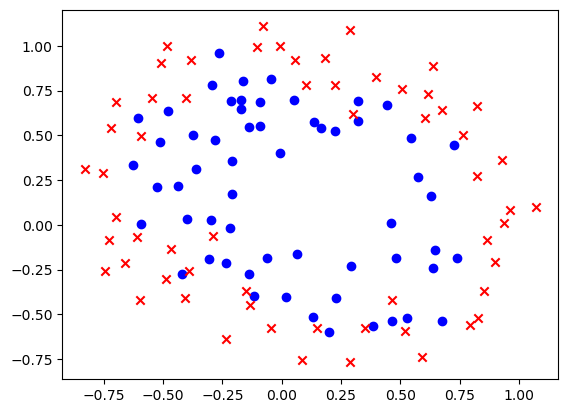

In [11]:
# Plot the data
%matplotlib inline 
import matplotlib.pyplot as plt

plt.scatter(X[y==1, 0], X[y==1, 1], marker='o', c='b') #positive samples
plt.scatter(X[y==0, 0], X[y==0, 1], marker='x', c='r') #negative samples
plt.show()

In order to implement Regularized Logistic Regression we must change only the term of the partial derivative (the gradient) of the cost function:

$\frac{\partial}{\partial w_j} J(w) = {1 \over m} \sum_{i=1}^m{(f_w(x^{(i)}) - y^{(i)}) x_j^{(i)}}$.

which in the case of Regularized Logistic Regression is given by:

$\frac{\partial}{\partial w_j} J(w) = {1 \over m} \sum_{i=1}^m{(f_w(x^{(i)}) - y^{(i)}) x_j^{(i)}+2{\lambda \over m}w_j}$

But remember that we do not want to regularise the bias term.

<font color=blue>Implement the Regularized Logistic Regression in Python.</font>

In [12]:
def sigmoid(X):
    '''
    Computes the Sigmoid function of the input argument X.
    '''
    return 1.0/(1+np.exp(-X))

In [13]:
def GradientDescent_logistic_reg(X, y, max_iterations=10000, alpha=0.1, epsilon = 0.0000001, lam = 1):
    # Your Code Here
    # ...
    
    
            
    return [w, np.squeeze(J)]

We bring here also the functions we defined last time to classify new data, and to generate new features

In [14]:
def classifyVector(X, w):
    '''
    Evaluate the Logistic Regression model with parameters w,
    and return the predicted label of x.
    '''
    prob = sigmoid(np.dot(X, w))
    ret = np.zeros_like(prob) # These next three lines are just in order to be able to deal with single (vector) or multiple (matrix) inputs
    ret[prob > 0.5] = 1
    ret = ret.squeeze()
    return ret

In [15]:
def mapFeatureAndNormalise_AllQuadTerms(x1, x2, degree = 6, preCalcMeans = None, preCalcStd = None):
    '''
    Maps 2D features to quadratic features.
    Returns a new feature vector with more features, comprising of
    x1, x2, x1^2, x2^2, x1*x2, x1*x2^2, etc...
    '''
    
    x1 = x1.reshape(-1, 1) # make it into a column vector
    x2 = x2.reshape(-1, 1) # make it into a column vector

    DesignMatrix = np.ones_like(x1) # start with a column of ones
    
    for i in range(1, degree + 1):
        for j in range(i + 1):
            c = (x1 ** (i - j)) * (x2 ** j)
            DesignMatrix = np.append(DesignMatrix, c, axis=1)

    # Calculate means and standard deviation if not provided
    if preCalcMeans is None:
        mu = DesignMatrix.mean(axis = 0)
    else:
        mu = preCalcMeans
        
    if preCalcStd is None:
        sigma = DesignMatrix.std(axis = 0, ddof=1)
    else:
        sigma = preCalcStd            
            
    # Scale features and set them to zero mean (standarize)
    # normalize everything except X0 (the artificial first feature that we set to ones)
    for i in range(1, DesignMatrix.shape[1]):
        DesignMatrix[:,i] = (DesignMatrix[:,i] - mu[i]) / sigma[i];

    return DesignMatrix, mu, sigma

In [16]:
# Accept this function as is, you can think of it as creating a 3D surface and "cutting" it at 0.5
def plotDecisionBoundary_withEmbeddedFeatures(X, y, w, degrees, means, sigmas):    
    #Plot data
    plt.scatter(X[y==1, 0], X[y==1, 1], marker='o', c='b') #positive samples
    plt.scatter(X[y==0, 0], X[y==0, 1], marker='x', c='r') #negative samples

    #Plot Decision Boundary
    u = np.linspace(min(X[:,0]), max(X[:,0]), 50)
    v = np.linspace(min(X[:,1]), max(X[:,1]), 50)
    z = np.zeros(shape=(len(u), len(v)))
    for i in range(len(u)):
        for j in range(len(v)):        
            feature, _, _ = mapFeatureAndNormalise_AllQuadTerms(x1 = np.array(u[i]), x2 = np.array(v[j]), degree = degrees, preCalcMeans = means, preCalcStd=sigmas)
            z[i, j] = sigmoid(feature.dot(w))
            
    z = z.T

    cs = plt.contour(u, v, z, levels=[0.5])
    plt.clabel(cs, inline=1, fontsize=10)
    plt.show()

<font color=blue>Keep the number of degrees to 15, and use your gradient descent function with different values for $\lambda$ in order to avoid under/overfitting. What value of $\lambda$ gives the best accuracy on your training set? </font>

In [17]:
# Your Code Here


<font color=blue>Use the `plotDecisionBoundary_withEmbeddedFeatures` function to draw the non-linear decision boundary you have found.</font>

In [18]:
#Your Code Here


---

*Your Answer Here*

---


# 4.3 Using sklearn

This section has no exercises. Your task is to read the manual, and understand how to repeat everything we have done up to now using the functions available in the library scikit-learn.

To get you started, this is the overview manual page for linear models: https://scikit-learn.org/stable/modules/linear_model.html

### Linear Regression

Read the manual page here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression

In [19]:
# Load the House dataset
with open('HouseData.pkl', 'rb') as f:
    X, y = pickle.load(f)
    
print (X.shape)
print (y.shape)

size = X[:, 0]
size = size.reshape(-1, 1)

(47, 2)
(47,)


In [20]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(size, y) # Note that we do not pass the bias feature explicitly, as by default the linear model adds it (it is the "intercept")

print(model.intercept_, model.coef_)

71270.49244872911 [134.52528772]


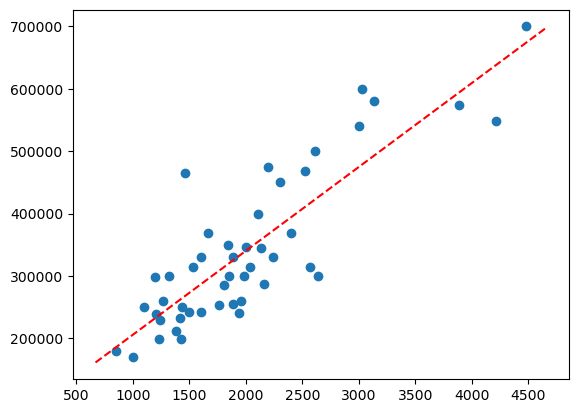

In [21]:
plt.scatter(size, y)

axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = model.intercept_ + model.coef_[0] * x_vals
plt.plot(x_vals, y_vals, 'r--')

In [22]:
#predict values on the training set
test_sizes = np.array([1000, 2500, 3200, 4000])
test_sizes = test_sizes.reshape(-1, 1)

model.predict(test_sizes)

array([205795.78016897, 407583.71174933, 501751.4131535 , 609371.64332969])

Now we can repeat the process, but using the standard scaler of scikit-learn to standardise the features before we start: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(size)
print("Mean:", scaler.mean_, "Var:", scaler.var_)
size_scaled = scaler.transform(size)

Mean: [2000.68085106] Var: [618114.55771842]


In [24]:
model.fit(size_scaled, y)

print(model.intercept_, model.coef_)

340412.6595744681 [105764.13349282]


The `StandardScaler` object, once fit, keeps track of the way it did the scaling, and can be used again with any new data.

In [25]:
test_sizes = np.array([1000, 2500, 3200, 4000])
test_sizes = test_sizes.reshape(-1, 1)
test_sizes = scaler.transform(test_sizes) # normalise them the same way as we did for the training set, before we pass them through our model
model.predict(test_sizes)

array([205795.78016897, 407583.71174933, 501751.4131535 , 609371.64332969])

### Polynomial Regression

Read the manual page: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [26]:
from sklearn.preprocessing import PolynomialFeatures

In [27]:
# Load the House dataset
with open('PolynomialData.pkl', 'rb') as f:
    x, y = pickle.load(f)

print (x.shape)
print (y.shape)

(50, 1)
(50,)


In [28]:
poly = PolynomialFeatures(3, include_bias = False ) # up to degree-3 polynomial features, but do not include the bias term (degree 0 invented feature)
x_poly = poly.fit_transform(x)

scaler = StandardScaler()
scaler.fit(x_poly) 
print("Mean:", scaler.mean_, "Var:", scaler.var_)
x_poly = scaler.transform(x_poly)

Mean: [0.044      9.159792   2.36463944] Var: [   9.157856     55.85142897 2473.0161783 ]


In [29]:
model = linear_model.LinearRegression()
model.fit(x_poly, y)

LinearRegression()

In [30]:
print(model.intercept_, model.coef_)

7.845300302600001 [  1.86012922   7.43704704 -16.56649192]


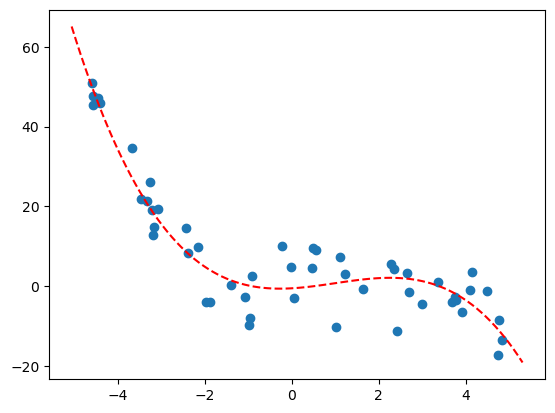

In [31]:
plt.scatter(x, y)

axes = plt.gca()
x_lims = np.array(axes.get_xlim())
xx = np.linspace(x_lims[0], x_lims[1], 100)

xx_poly = poly.fit_transform(xx.reshape(-1, 1))
xx_poly = scaler.transform(xx_poly)

y_vals = model.intercept_ + model.coef_ @ xx_poly.T
plt.plot(xx, y_vals, 'r--')

In [32]:
#predict values on the training set
x_test = np.array([-4, 0, 4])
x_test = x_test.reshape(-1, 1)

x_test_poly = poly.transform(x_test)
x_test_poly = scaler.transform(x_test_poly)

y_hat = model.predict(x_test_poly)
y_hat

array([34.27472471, -0.50926569, -3.44883471])

### Logistic Regression

Read the manual page: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

In [33]:
# Load the synthetic dataset
import pickle

with open('RingsData.pkl', 'rb') as f:
    X, y = pickle.load(f)

print (X.shape)
print (y.shape)

(117, 2)
(117,)


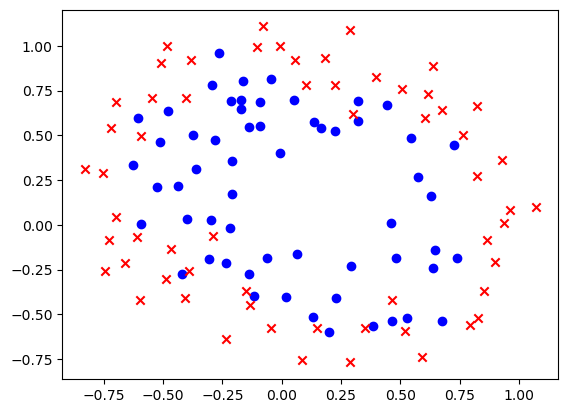

In [34]:
# Plot the data
%matplotlib inline 
import matplotlib.pyplot as plt

plt.scatter(X[y==1, 0], X[y==1, 1], marker='o', c='b') #positive samples
plt.scatter(X[y==0, 0], X[y==0, 1], marker='x', c='r') #negative samples
plt.show()

In [35]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter = 10000)
clf.fit(X, y)
clf.predict(X)

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

In [36]:
clf.predict_proba(X[:5]) # for the first 5 data points

array([[0.50682367, 0.49317633],
       [0.49834682, 0.50165318],
       [0.49131995, 0.50868005],
       [0.48100745, 0.51899255],
       [0.47277988, 0.52722012]])

In [37]:
# calculate accuracy
clf.score(X, y)

0.5470085470085471

This is no good, as expected there is no linear decision boundary that separates well the two classes. Now let's create polynomial features

In [38]:
poly = PolynomialFeatures(15) # up to second degree features
x_poly = poly.fit_transform(X)
x_poly.shape

(117, 136)

In [39]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter = 10000, penalty = None) # without regularisation, note that it takes ages to converge (see the warning message!)
clf.fit(x_poly, y)
clf.predict(x_poly)

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [40]:
clf.predict_proba(x_poly[:5]) # for the first 5 data points

array([[7.48512363e-13, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [3.46085878e-04, 9.99653914e-01],
       [8.59085282e-04, 9.99140915e-01]])

In [41]:
# calculate accuracy
clf.score(x_poly, y)

0.9829059829059829

We seem to be overfitting. Finally, let's add L2 regularisation

In [42]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter = 10000, penalty = 'l2')
clf.fit(x_poly, y)
clf.predict(x_poly)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [43]:
clf.predict_proba(x_poly[:5]) # for the first 5 data points

array([[0.27741371, 0.72258629],
       [0.25981727, 0.74018273],
       [0.27652901, 0.72347099],
       [0.2642877 , 0.7357123 ],
       [0.34582692, 0.65417308]])

In [44]:
# calculate accuracy
clf.score(x_poly, y)

0.8376068376068376

Do a confusion matrix. Read the manual page here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [45]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_poly)
confusion_matrix(y, y_pred)

array([[44, 15],
       [ 4, 54]], dtype=int64)

# 4.4 Training, Validation and Test set

Up to now we have been calculating performance on the training set. Here we will see how we can manage different dataset splits using scikit-learn.

In [46]:
# Load the synthetic dataset
import pickle

with open('RingsData.pkl', 'rb') as f:
    X, y = pickle.load(f)

print (X.shape)
print (y.shape)

(117, 2)
(117,)


<font color=blue>Using the classification dataset above. Split your dataset into a training and test set (80% random). Have a look at the manual page here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html</font>

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
# Your Code Here



<font color=blue>Use a polynomial model like before with logistic regression. Train it on the training set without regularisation. Then test on training and test set. Plot the final costs in the same plot for different degrees of the polynomial model, from 1 to 15.</font>

In [49]:
# Your Code Here



<font color=blue>What do you observe?</font>

---

*Your Answer Here*

---

<font color = blue>Now do 5-fold cross-validation. Then report the average performance and its standard deviation</font>

See the manual page at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

In [50]:
# Your Code Here
